In [1]:
import sys
sys.path.append('../src/')

from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import torch
import numpy as np
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
from tqdm import tqdm
from sae_model import SparseAutoencoder
import json
import os

models_dir = "../models/"

# Load model and tokenizer
model_name = "gpt2"
model = GPT2LMHeadModel.from_pretrained("gpt2", attn_implementation="eager")
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Set to evaluation mode
model.eval()

/Users/deniz/sae-project/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [2]:
LAYER_NUM = 7

# Hook setup
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output[0].detach()
    return hook

handle = model.transformer.h[LAYER_NUM].register_forward_hook(
    get_activation(f'layer_{LAYER_NUM}')
)

In [3]:
checkpoint = torch.load(models_dir + "sae_topk_final.pt", map_location='cpu')

# Extract config if saved, otherwise use defaults
if 'config' in checkpoint:
    config = checkpoint['config']
    sae = SparseAutoencoder(
        input_dim=config['input_dim'],
        hidden_dim=config['hidden_dim'],
        sparsity_coef=config['k'],  # k is the number of active features
        normalize_eps=config.get('normalize_eps', 1e-6)
    )
    state_dict = checkpoint['model_state_dict']
else:
    # Fallback if config not saved
    sae = SparseAutoencoder(input_dim=768, hidden_dim=3840, sparsity_coef=64)
    state_dict = checkpoint if isinstance(checkpoint, dict) and 'encoder.weight' in checkpoint else checkpoint['model_state_dict']

sae.load_state_dict(state_dict)
sae.eval()

SparseAutoencoder(
  (encoder): Linear(in_features=768, out_features=3840, bias=True)
  (decoder): Linear(in_features=3840, out_features=768, bias=False)
)

In [4]:
text = "Testing visually to see if the sparse encoder actually works"
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)


In [5]:
outputs = model(**inputs)
act = activations[f'layer_{LAYER_NUM}'][0]  # [seq_len, 768]

In [10]:
act.shape

torch.Size([11, 768])

In [6]:
act.shape

torch.Size([11, 768])

In [7]:
sae = SparseAutoencoder(
    input_dim=768,
    hidden_dim=3840,  # 5x expansion
    sparsity_coef=64,  # Keep top 64 features active (adjust based on desired sparsity)
    normalize_eps=1e-6
)

In [9]:
# Check reconstruction error

reconstructed, hidden = sae.forward(act)

In [11]:
reconstructed.shape

torch.Size([11, 768])

Text(0.5, 0.98, 'Activation Pattern - Original vs. Reconstructed')

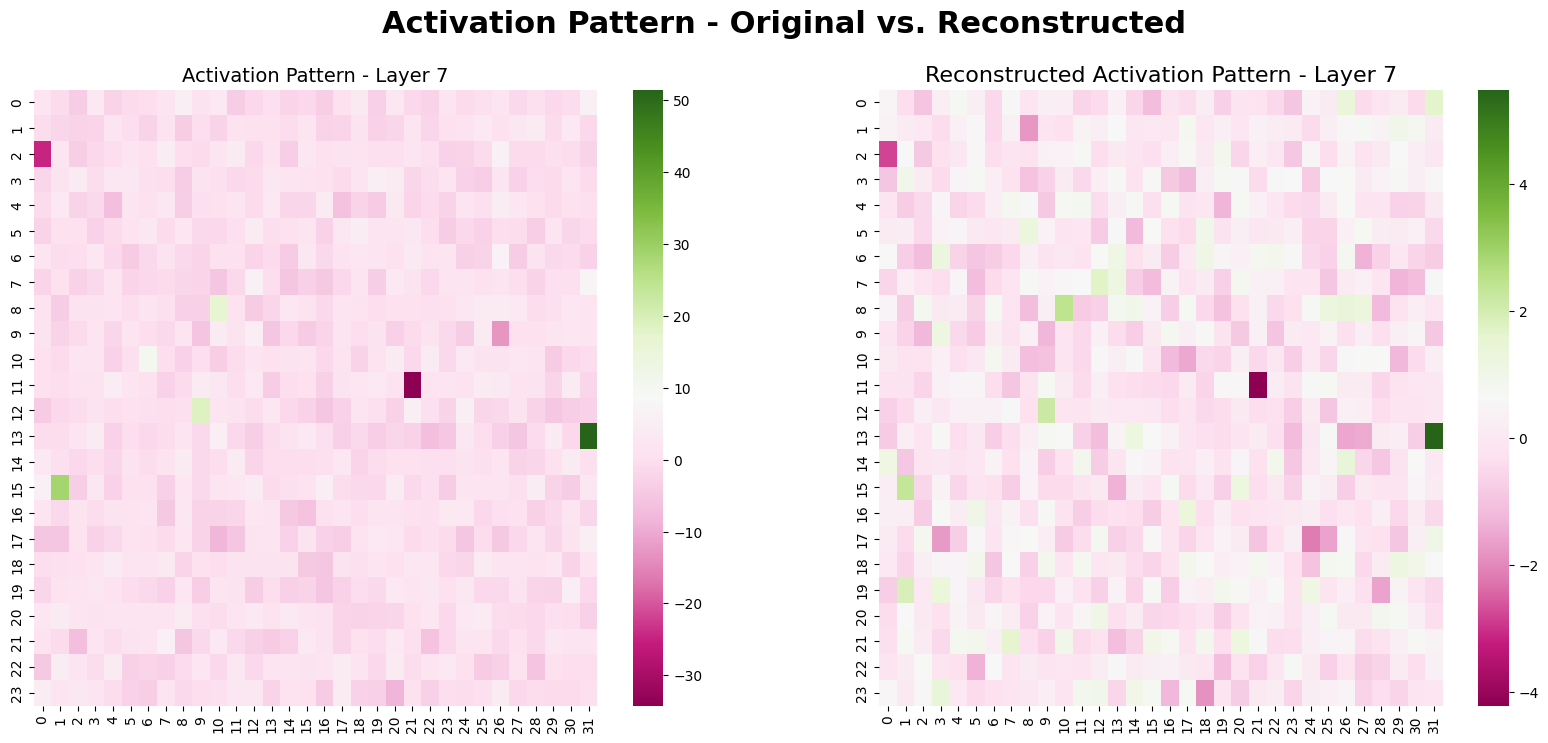

In [45]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(act.detach().numpy()[4].reshape(24,32),cmap="PiYG", ax = ax1)
ax1.set_title("Activation Pattern - Layer 7", fontsize=14)


sns.heatmap(reconstructed.detach().numpy()[4].reshape(24,32),cmap="PiYG", ax = ax2)
ax2.set_title("Reconstructed Activation Pattern - Layer 7", fontsize=16)

fig.suptitle(
    'Activation Pattern - Original vs. Reconstructed', 
    fontsize=22,           # Large font
    fontweight='bold',     # Bold
    y=0.98                 # Position (0.98 = near top)
)


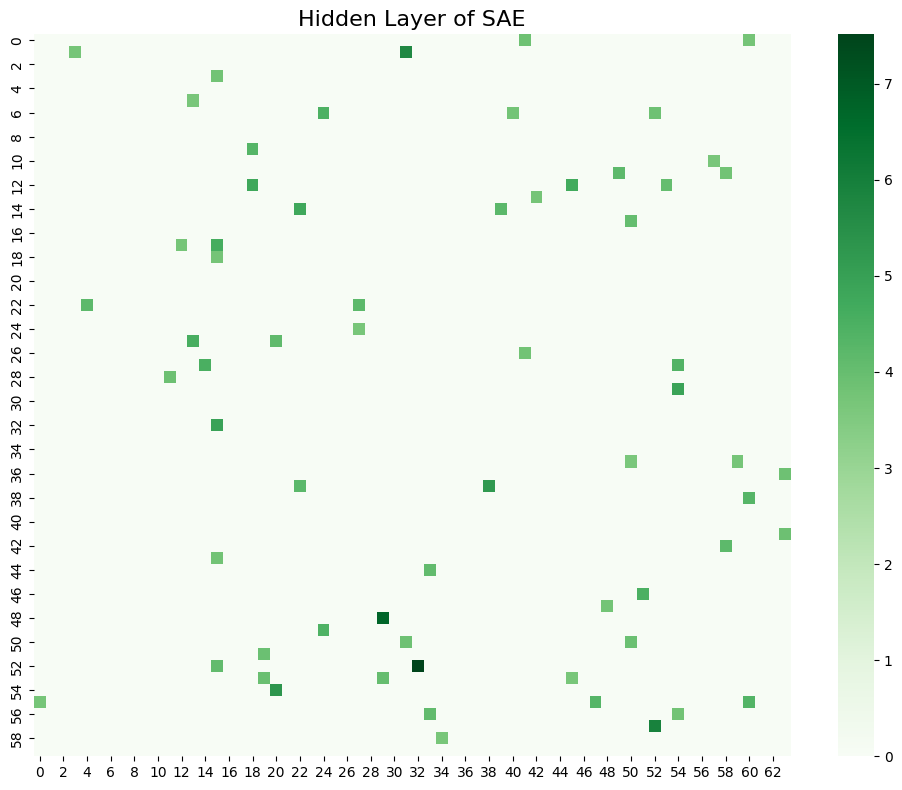

In [44]:
plt.figure(figsize=(10, 8))
sns.heatmap(hidden.detach().numpy()[4].reshape(60,64),cmap="Greens")
plt.title("Hidden Layer of SAE", fontsize=16)
plt.tight_layout()
plt.show()

In [53]:
from tqdm import tqdm
import numpy as np
import torch

activations = np.load("../data/activations_layer7.npy")[:10000]

for _ in tqdm(range(1), desc="Running SAE"):
    x_recon, h_sparse = sae(torch.tensor(activations))

print("\nForward pass:")
print(f"  Input shape: {activations.shape}")
print(f"  Sparse hidden shape: {h_sparse.shape}")
print(f"  Output shape: {x_recon.shape}")

# Test loss
recon_loss, loss_dict = sae.compute_loss(torch.tensor(activations), x_recon, h_sparse)


Running SAE: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


Forward pass:
  Input shape: (10000, 768)
  Sparse hidden shape: torch.Size([10000, 3840])
  Output shape: torch.Size([10000, 768])
